# Clasificación con redes neuronales
En el ejercicio anterior, creaste y entrenaste una red neuronal para predecir precios de casas utilizando el [Ames Housing Dataset](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques). Esto consistió en resolver un problema de *regresión*, sin embargo ahora entrenarás una red para resolver un problema de *clasificación*.

En este ejercicio utilizarás el ["Churn Modeling Dataset"](https://www.kaggle.com/datasets/shivan118/churn-modeling-dataset) para predecir si un cliente cerrará su cuenta bancaria o si continuará siendo cliente de el banco. El dataset contiene información de distintos clientes como su género, su puntuación crediticia, el país de residencia etc. donde para cada cliente se indica si ha dejado el banco (exited = 1) o no (exited = 0).

Tu trabajo será poder predecir la probabilidad de que un cliente determinado actual deje el banco.

De acuerdo a lo visto en clase responde:
1. ¿En el contexto de **clasificación binaria** que función de costo deberías utilizar para entrenar la red?
>Binary Cross Entropy Loss
2. ¿Cuál función de activación necesitas en la última capa para predecir una probabilidad de ser clase 1?
>Sigmoide


### Importando las librerías

In [1]:
import numpy as np
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt

## Parte 1 - Preprocesamiento de datos

Comenzaremos importando el dataset y visualizando los datos para entender qué necesitamos modificar antes de entrenar el algoritmo.

### Importando y visualizando los datos
utilizaremos dataset.info() para observar la cantidad de columnas que tenemos, la cantidad de datos y el tipo de dato de cada uno

In [2]:
dataset = pd.read_csv('Churn_Modelling.csv')
# Las primeras tres columnas no importan para la predicción por lo que las ignoraremos
full_data = dataset.iloc[:, 3:-1]
full_labels = dataset.iloc[:, -1].values

full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
dtypes: float64(2), int64(6), object(2)
memory usage: 781.4+ KB


En base a la información anterior responde:
1. ¿Cuantas variables de entrada tiene cada datapoint del dataset?
>10
2. ¿Cuantos datos tiene el dataset?
>10000
3. ¿Cuantas y cuales columnas **no** son de tipo numérico?
>Son 2, "Geography" y "Gender"

Ejecuta la siguiente linea para visualizar algunos datos de entrenamiento junto con sus etiquetas. Esto nos ayudará a entender qué tipo de pre procesamiento necesitamos antes de entrenar.

In [3]:
print("Datos", full_data.head(3))
print("Etiquetas", full_labels[:3])


# TODO: Define una lista con los nombres de las columnas con valores categóricos
object_columns = (full_data.dtypes == 'object')
object_columns = list(object_columns[object_columns].index)
#[["CreditScore",0],["Geography",1],["Gender",2],["Age",3],["Tenure",4],["Balance",5],["NumOfProducts",6],["HasCrCard",7],["IsActiveMember",8],["EstimatedSalary",9]]

Datos    CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0          619    France  Female   42       2       0.00              1   
1          608     Spain  Female   41       1   83807.86              1   
2          502    France  Female   42       8  159660.80              3   

   HasCrCard  IsActiveMember  EstimatedSalary  
0          1               1        101348.88  
1          0               1        112542.58  
2          1               0        113931.57  
Etiquetas [1 0 1]


### Dividiendo los datos en entrenamiento y validación
Notarás que este dataset solo te dá los datos de entrenamiento, por lo que los dividiremos en entrenamiento y validación.

En este caso utilizaremos la utilería de sklearn [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) para realizar la divición.

In [4]:
from sklearn.model_selection import train_test_split
# TODO: divide los datos en entrenamiento y validación,
# asignando el 20% de los datos a validación/prueba
X_train, X_val, y_train, y_val = train_test_split(full_data, full_labels, test_size=0.2, random_state=0)

print(f"Dimensionality Training: {X_train.shape}, Tags {y_train.shape}")
print(f"Dimensionality Validation: {X_val.shape}, Tags {y_val.shape}")

Dimensionality Training: (8000, 10), Tags (8000,)
Dimensionality Validation: (2000, 10), Tags (2000,)


### Codificando datos categóricos
Al igual que en el problema de las casas, podrás notar que algunas columnas son de tipo string mientras que la red neuronal necesita valores numéricos para poder entrenar. Por lo tanto aplicaremos un pre procesamiento similar al ejercicio anterior.

Utiliza la clase [OrdinalEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html) de sklearn para transformar todas las columnas categóricas a un valor entero. Recuerda que esta clase espera que los datos ingresados sean del tipo.

En este dataset, además de transformar los valores categóricos a enteros, adicionalmente normalizaremos los datos de entrada utilizando la clase [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) utilizada en el ejercicio de PCA. 

De esta forma, nuestro procesamiento de datos se verá de la siguiente forma:
1. Ajustar el codificador de columnas categóricas a los datos de entrenamiento
2. Ajustar el normalizador a los datos de entrenamiento
3. Aplicar el codificador al dataset indicado (train/val/test)
4. Remover los valores NaN remplazándolos por -1
5. Aplicar el normalizador al dataset indicado (train/val/test)

En la siguiente celda, completa el código faltante para preprocesar los datos. Recuerda que anteriormente has definido las columnas de tipo categórico. Utiliza la variable object_columns para aplicar el OrdinalEncoder a las columnas categóricas de tus datos.

In [5]:
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.preprocessing import StandardScaler

# TODO: Define y ajusta un codificador (OrdinalEncoder)
# para transformar las columnas categóricas a valores numéricos
# usando los datos de entrenamiento (X_train)
feat_encoder = OrdinalEncoder(handle_unknown='use_encoded_value',
                             unknown_value=-1)
feat_encoder.fit(X_train[object_columns])

# Transformando categórigos a numéricos
X_transformed = X_train.copy()
X_transformed[object_columns] = feat_encoder.transform(X_train[object_columns])

# TODO: Define y ajusta un normalizador (StandardScaler)
# con los datos de entrenamiento transformados (X_transformed)
normalizer = StandardScaler().fit(X_transformed)

In [6]:
def apply_preprocessing(dataset, feat_encoder, normalizer, obj_cols):
    '''
        Aplica el preprocesamiento de codificar y normalizar los datos en datasets, y remplaza los valores NaN por -1
        args:
        - dataset (pd.DataFrame): Conjunto de datos
        - feat_encoder (OrdinalEncoder): instancia de codificador para las variables de entrada ajustado con datos de entrenamiento
        returns:
        - transformed_dataset (np.array): dataset transformado
    '''
    transformed_dataset = dataset.copy()
    # Transformar los valores categóricos del dataset a enteros.
    transformed_dataset[obj_cols] = feat_encoder.transform(dataset[obj_cols])

    # Normalizar los datos transformados
    transformed_array = transformed_dataset.to_numpy()
    transformed_dataset = normalizer.transform(transformed_array)

    # Reemplazando valores NaN con -1
    transformed_dataset[np.isnan(transformed_dataset)] = -1
    return transformed_dataset

Ahora que has terminado de definir el pre procesamiento de datos, aplícalo a los dos conjuntos de datos (entrenamiento y validación)

In [7]:
X_train = apply_preprocessing(X_train, feat_encoder, normalizer, object_columns)
print("Entrenamiento shapes", X_train.shape, y_train.shape)
print("Entrenamiento pre procesado", X_train[:,:3])

# TODO: Aplica el pre procesamiento de datos a los datos de validación
X_val = apply_preprocessing(X_val, feat_encoder, normalizer, object_columns)
print("Validacion shapes", X_val.shape, y_val.shape)
print("Validacion pre procesado", X_val[:,:3])

Entrenamiento shapes (8000, 10) (8000,)
Entrenamiento pre procesado [[ 0.16958176  1.51919821 -1.09168714]
 [-2.30455945  0.3131264   0.91601335]
 [-1.19119591 -0.89294542 -1.09168714]
 ...
 [ 0.9015152  -0.89294542  0.91601335]
 [-0.62420521  1.51919821 -1.09168714]
 [-0.28401079  0.3131264  -1.09168714]]
Validacion shapes (2000, 10) (2000,)
Validacion pre procesado [[-0.55204276  0.3131264  -1.09168714]
 [-1.31490297 -0.89294542 -1.09168714]
 [ 0.57162971  1.51919821 -1.09168714]
 ...
 [-0.74791227  1.51919821  0.91601335]
 [-0.00566991  0.3131264   0.91601335]
 [-0.79945688  0.3131264   0.91601335]]


c:\Users\Usuario\.conda\envs\sistemas_inteligentes\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Usuario\.conda\envs\sistemas_inteligentes\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


## Creando los dataloader
Ahora que hemos limpiado los datos podemos crear  los data loaders para entrenamiento y validación. Ejecuta la siguiente celda para ello.

In [8]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
class BankDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data.astype('float32')
        self.labels = labels.astype('float32')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        datapoint = self.data[idx]
        label = self.labels[idx]
        label = np.expand_dims(label, 0) # Transformarlo a vector de 1x1
        return datapoint, label

# Datasets
train_dataset = BankDataset(X_train, y_train)
val_dataset = BankDataset(X_val, y_val)

# Parte 2 - Utilerias
Corre la siguiente celda para poder visualizar las gráficas de entrenamiento

In [9]:
class PlotLosses():
    def __init__(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, train_loss, val_loss):        
        self.x.append(self.i)
        self.losses.append(train_loss)
        self.val_losses.append(val_loss)
        self.i += 1
        plt.plot(self.x, self.losses, label="Costo de entrenamiento promedio")
        plt.plot(self.x, self.val_losses, label="Costo de validación promedio")
        plt.xlabel('epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

## Parte 2 - Entrenamiento
Es momento de crear tu red! puedes basarte en el ejercicio anterior para definirla. En la siguiente celda, define tu red neuronal. Al ser este un problema de clasificación, recuerda seleccionar una función de activación apropiada para la última capa. Puedes referirte a la documentación de pytorch sobre [funciones de activación](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity).

### Define tu red neuronal

In [54]:
# TODO: Calcula las variables de entrada y salida para algun punto de X_train
input_dims = train_dataset.data.shape[-1]
#print(train_dataset.data.shape)
output_dims = 1
print(f"Definiendo red con {input_dims} variables de entradas y {output_dims} variables de salida")

# TODO: Define la red neuronal
net = nn.Sequential(
        nn.Linear(input_dims, 100),   # capa lineal entran ..., salen ... features
        nn.ReLU(),             # activación ReLu a la lineal anterior
        nn.Linear(100, 100),   # capa lineal entran ... salen ... features
        nn.ReLU(),             # activación ReLu a la lineal anterior
        nn.Linear(100, 1),   # capa de clasificación binaria
        nn.Sigmoid()
    )

Definiendo red con 10 variables de entradas y 1 variables de salida


### Entrenando la red
En la siguiente celda:
- Define el optimizador a utilizar
- Define una función de costo apropiada al problema
- Completa el algoritmo de descenso de gradiente para optimizar la red.

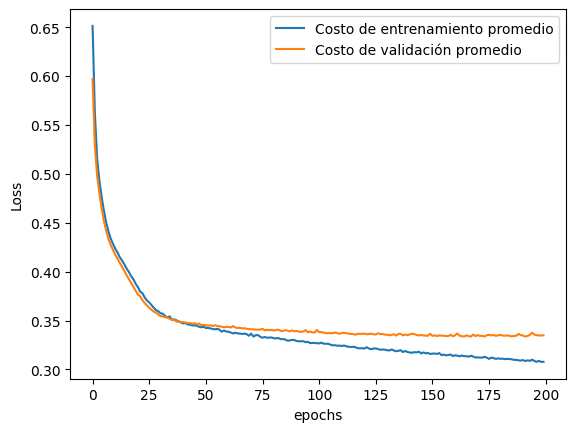

epoch: 199 	 train loss: 0.30785887345435126 	 val_loss: 0.334866045974195


In [55]:
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline
import time
# Graficas
loss_plot = PlotLosses()

# hiperparametros
learning_rate = 1e-4
batch_size = 128
epochs = 200

# TODO: Declara el optimizador
# https://pytorch.org/docs/stable/optim.html
optimizer = optim.Adam(net.parameters(),
                       lr=learning_rate)

# TODO: Declara una función de costo apropiada para clasificación
# https://pytorch.org/docs/stable/nn.html#loss-functions
cost_function = nn.BCELoss()

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

for epoch in range(epochs):
    train_loss = 0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        # Aplicando descenso de gradiente 
        # ======== Start ============
        # TODO: calcula las predicciones del modelo para x_batch
        outputs = net(x_batch)
        # TODO: Calcula el costo de las predictiones, contra las etiquetas y_batch
        loss = cost_function(outputs, torch.tensor(y_batch))
        # TODO: Calcula los gradientes
        loss.backward()
        # TODO: Actualiza los pesos
        optimizer.step()
        # ======== End ============
        train_loss += loss.item()

    # Loss entrenamiento promedio por minibatch
    train_loss = train_loss/len(train_loader)

    # Validación
    val_loss = 0.0
    for i, data in enumerate(val_loader, 0):
        inputs, labels = data
        with torch.inference_mode():
            # TODO: Calcula la inferencia y costo de validación
            outputs = net.forward(inputs)
            loss = loss = cost_function(outputs,labels)
            val_loss += loss.item()
    val_loss = val_loss/len(val_loader)
    # Actualizamos la gráfica de las curvas de entrenamiento
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(0.5)
    loss_plot.on_epoch_end(epoch, train_loss, val_loss)
    print(f"epoch: {epoch} \t train loss: {np.mean(train_loss)} \t val_loss: {val_loss}")

## Part 4 - Evaluación del modelo
Ahora que has entrenado tu modelo, vamos a utilizarlo para evaluarlo en un nuevo punto nunca antes visto.

### Predice el resultado para la siguiente observación:
Utiliza tu modelo para predecir si el siguiente cliente dejará el banco:
- Puntuación crediticia: 600
- Geografía: Francia
- Género: Masculino
- Antiguedad: 3 years
- Edad: 40 years
- Balance: $60,000
- Cantidad de productos: 2
- Tiene tarjeta: si
- Es miembro activo: si
- Salario estimado: $50,000

Responde, según al modelo entrenado ¿Deberíamos decirle adios a este cliente?

In [48]:
# Visualizando las columnas
print("Columnas")
full_data.info()

Columnas
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
dtypes: float64(2), int64(6), object(2)
memory usage: 781.4+ KB


In [13]:
# Visualizando el mapeo palabra-> numero del encoder
print("Categorias")
feat_encoder.categories_

Categorias


[array(['France', 'Germany', 'Spain'], dtype=object),
 array(['Female', 'Male'], dtype=object)]

In [60]:
# TODO: Define el datapoint correspondiente al cliente para el cual haremos la predicción
datapoint = np.array([600,0,1,40,3,60000,2,1,1,50000])
# Aplicando el preprocesamiento (Normalizando con los valores encontrados en entrenamiento)
# Y transformando a tensor para poder propagar el dato por la red
datapoint = datapoint.reshape(1, -1)
datapoint = normalizer.transform(datapoint)
inp_tensor = torch.from_numpy(datapoint).float()

# TODO: Imprime la predicción para el cliente y responde la pregunta:
# El cliente dejará el banco?
out = net(inp_tensor)
print(out)

###############################
#La predicción de la red es 0.0371, al ser esto cercano a 0, la red predice que el cliente no sale del banco, es decir, se queda 
###############################

tensor([[0.0371]], grad_fn=<SigmoidBackward0>)


c:\Users\Usuario\.conda\envs\sistemas_inteligentes\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Nuestro modelo debería predecir que el cliente decide quedarse en el banco (:

## Notas:
1. Nota como el normalizador espera los datos de entrada en la forma (N, D). En el caso de 1 solo cliente, datapoint.shape debería ser (1,9). Podemos utilizar np.reshape() para obtener el shape deseado
2. Nota como "francia" no se ingresa como entrada en el datapoint sino el número que asigna el OrdinalEncoder a esa palabra.